## [ ML ] Data_Salaries 예측
---


**[  data  ]   : 조사연도, 숙련도, 고용형태, 직업군, 급여, 통화, 직원 거주지, 원격업무 비중, 회사 위치, 회사 크기**  
**[ target ] : 달러화한 급여**  
  
**=> data 중 조사연도, 급여 제외 모두 입력**  

---

### <span style = 'color : red'> 회귀 : 입력하는 data 따라, 급여는 얼마가 될 것인가 </span>

### 사용 모델 : <span style='background:yellow'> 의사결정트리 -> 랜덤포레스트, 그래디언트부스팅, 히스트그래디언팅 </span>

### 과정 :  
### <span style='background:yellow'> 데이터 로딩/확인 - 전처리 - 분리 - all_estimators로 모델 고르기  </span>  
### <span style='background:yellow'> 선택 모델 => 객체생성 - 훈련 - CV+파라미터조절=그리드서치 - 평가 - 예측 </span>

---

### <span style = 'color : blue'> [ 모듈 로딩 ] </span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')   # 경고무시
import platform
from sklearn.model_selection import GridSearchCV

# 글씨체
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
else:
    plt.rc('font', family='AppleGothic')

# 그래프 음수 가능
plt.rcParams['axes.unicode_minus'] = False

### <span style = 'color : blue'>  [ 데이터 불러오기 ] </span>

In [2]:
# 데이터 읽어오기
df = pd.read_csv('./data/ds_salaries_ori.csv')
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary_in_usd
0,2020,MI,FT,Scientist,70000,EUR,DE,0,DE,L,79833
1,2020,SE,FT,Scientist,260000,USD,JP,0,JP,S,260000
2,2020,SE,FT,Engineer,85000,GBP,GB,50,GB,M,109024
3,2020,MI,FT,Analyst,20000,USD,HN,0,HN,S,20000
4,2020,SE,FT,Engineer,150000,USD,US,50,US,L,150000


In [3]:
# 데이터 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606 entries, 0 to 605
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           606 non-null    int64 
 1   experience_level    606 non-null    object
 2   employment_type     606 non-null    object
 3   job_title           606 non-null    object
 4   salary              606 non-null    int64 
 5   salary_currency     606 non-null    object
 6   employee_residence  606 non-null    object
 7   remote_ratio        606 non-null    int64 
 8   company_location    606 non-null    object
 9   company_size        606 non-null    object
 10  salary_in_usd       606 non-null    int64 
dtypes: int64(4), object(7)
memory usage: 52.2+ KB


In [4]:
# 결측치 개수 확인
df.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
salary_in_usd         0
dtype: int64

---

### <span style = 'color : blue'> [ 전처리 ] </span>

미리 엑셀로 'job_title'의 직업들을 1차적으로 수정한 상태  (53가지 -> 8가지)  

ex)  
'Machine Learning Developer',  
'Applied Machine Learning Scientist', 'Data Analytics Manager',  
'Data Specialist', 'Data Architect','BI Data Analyst','Research Scientist', ... 
  
=> Analyst, Architect, Consultant, Developer, Engineer, Manager, Scientist, Data 

In [5]:
df['job_title'].unique()

array(['Scientist', 'Engineer', 'Analyst', 'Consultant', 'Manager',
       'Data', 'Developer', 'Architect'], dtype=object)

---

'salary'까지 넣었다가 score가 좋았는데,  
  
생각해보니 타겟인 'salary_in_usd'를 us달러 비율로 바꾸기 전의 값이었기 때문에  
  
특성 중요도도 높고, 모델 자체의 score가 좋게 나올 수 밖에 없었음을 깨닫게 됨  
  
=> 타겟값을 그대로 넣어버린셈. 차후에 해당 피처 삭제   



In [6]:
# 불필요 피처 삭제
df.drop(['work_year','salary'], axis=1, inplace=True)
# salary는 salary_in_usd와 비슷한 피처라 삭제
# employee_residence는 company_location와 비슷

In [7]:
df.columns

Index(['experience_level', 'employment_type', 'job_title', 'salary_currency',
       'employee_residence', 'remote_ratio', 'company_location',
       'company_size', 'salary_in_usd'],
      dtype='object')

---

### <span style = 'color : blue'> One-Hot Encoding </span>

처음엔 했다가,  
타겟을 제외한 모든 피처들이 범주형, 특히 'job_title' 피처는 1차적으로 묶어주었음에도 8개  
원-핫 코딩을 하면 너무 많은 추가적인 피처들이 생김  
  
컬럼이 너무 많아지면?  
각 특성의 범주에 들어가는 변수들이 모두 새로운 특성이 되므로 범주의 종류가 많아질수록 전체 데이터의 특성이 엄청나게 늘어남  
(이렇게 많아지는걸 high cardinality라고 말함) 이럴경우 원핫인코딩이 좋지 않음  

### <span style = 'color : blue'> LabelEncoder </span>

In [8]:
from sklearn.preprocessing import LabelEncoder
la = LabelEncoder()

feature = ['experience_level', 'employment_type', 'job_title',
       'salary_currency', 'employee_residence', 'remote_ratio',
       'company_location', 'company_size']

for i in feature:
    la.fit(df[i])
    df[i] = la.transform(df[i])

In [9]:
df

,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary_in_usd
0,2,2,7,7,14,0,12,0,79833
1,3,2,7,16,32,0,29,2,260000
2,3,2,5,8,20,1,18,1,109024
3,2,2,0,16,23,0,20,2,20000
4,3,2,5,16,55,1,48,0,150000
...,...,...,...,...,...,...,...,...,...
601,3,2,5,16,55,2,48,1,154000
602,3,2,5,16,55,2,48,1,126000
603,3,2,0,16,55,0,48,1,129000
604,3,2,0,16,55,2,48,1,150000


---

### <span style = 'color : blue'> [ 학습 & 테스트 데이터 분리 ] </span>

In [31]:
df

,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary_in_usd
0,2,2,7,7,14,0,12,0,79833
1,3,2,7,16,32,0,29,2,260000
2,3,2,5,8,20,1,18,1,109024
3,2,2,0,16,23,0,20,2,20000
4,3,2,5,16,55,1,48,0,150000
...,...,...,...,...,...,...,...,...,...
601,3,2,5,16,55,2,48,1,154000
602,3,2,5,16,55,2,48,1,126000
603,3,2,0,16,55,0,48,1,129000
604,3,2,0,16,55,2,48,1,150000


In [35]:
# NumPy 배열 추출
X = df.iloc[:, :-1].values
y = df['salary_in_usd'].values
print('X.shape: {},  y.shape: {}'.format(X.shape, y.shape))

X.shape: (606, 8),  y.shape: (606,)


In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
# 데이터가 적어서 test자료를 25%, 15%, 10% 해보았는데, 기본값이 제일 나았음
# stratify 파라미터는 회귀보다 분류에서 쓴다고 함 (like stratifiedKFold)

In [38]:
train_test_split(X, y)

[array([[ 3,  2,  7, ...,  2, 48,  1],
        [ 2,  2,  7, ...,  2, 25,  2],
        [ 2,  2,  5, ...,  0, 48,  1],
        ...,
        [ 3,  2,  7, ...,  0, 48,  1],
        [ 3,  2,  5, ...,  0, 48,  1],
        [ 2,  2,  0, ...,  2, 48,  0]], dtype=int64),
 array([[ 3,  2,  0, ...,  2, 48,  1],
        [ 3,  2,  6, ...,  2, 48,  1],
        [ 2,  2,  7, ...,  2,  6,  0],
        ...,
        [ 2,  2,  0, ...,  2, 16,  1],
        [ 2,  2,  5, ...,  2, 18,  1],
        [ 2,  2,  5, ...,  2, 16,  2]], dtype=int64),
 array([140000,  16904, 206699, 162674, 170000, 213120,  93700, 188000,
        113000,  19609,  42197,   6072,  39263,  65949,  93427,  87932,
         98158,  51519, 214000, 106260, 145000, 132000,  88654,   9466,
        165400, 205300, 101570, 120000, 200000,  70139,  18442,  52351,
          4000,  62726,  20171, 117104, 174000, 110037,   2859, 126500,
         49461, 215300, 216000,  40038,  25000, 170000, 220110,  93000,
        147000,  51064,  40481,  69000,  480

---

### <span style = 'color : blue'> [ all_estimators로 모델 고르기 ] </span>

In [12]:
# 필터 타입에 해당하는 sklearn에 존재하는 모든 모델 이름과 객체 리스트로 반환
from sklearn.utils import all_estimators
models = all_estimators(type_filter = 'regressor')

# 각 모델들 훈련시키고 정확도 추출
scores = []
for name, model in models:
    try:
        # 모델 객체 생성
        md = model()
        # 학습
        md.fit(X_train, y_train)
        # 평가
        result = md.score(X_test, y_test)
    
        scores.append((name, np.round(result,3)))
    except:
        pass

In [13]:
scores

# 'HistGradientBoostingRegressor', 0.499
# 'GradientBoostingRegressor', 0.466
# 'RandomForestRegressor', 0.482

[('ARDRegression', 0.307),
 ('AdaBoostRegressor', 0.149),
 ('BaggingRegressor', 0.465),
 ('BayesianRidge', 0.304),
 ('CCA', -0.445),
 ('DecisionTreeRegressor', 0.327),
 ('DummyRegressor', -0.0),
 ('ElasticNet', 0.312),
 ('ElasticNetCV', 0.183),
 ('ExtraTreeRegressor', 0.275),
 ('ExtraTreesRegressor', 0.417),
 ('GammaRegressor', 0.3),
 ('GaussianProcessRegressor', -0.059),
 ('GradientBoostingRegressor', 0.437),
 ('HistGradientBoostingRegressor', 0.489),
 ('HuberRegressor', 0.262),
 ('KNeighborsRegressor', 0.232),
 ('KernelRidge', 0.31),
 ('Lars', 0.282),
 ('LarsCV', 0.295),
 ('Lasso', 0.282),
 ('LassoCV', 0.3),
 ('LassoLars', 0.282),
 ('LassoLarsCV', 0.295),
 ('LassoLarsIC', 0.3),
 ('LinearRegression', 0.282),
 ('LinearSVR', 0.161),
 ('MLPRegressor', -2.679),
 ('NuSVR', -0.013),
 ('OrthogonalMatchingPursuit', 0.242),
 ('OrthogonalMatchingPursuitCV', 0.272),
 ('PLSCanonical', -1.51),
 ('PLSRegression', 0.283),
 ('PassiveAggressiveRegressor', 0.285),
 ('PoissonRegressor', 0.32),
 ('Quanti

#### <span style='background:yellow'> 원-핫 인코딩(피처수), train-test 분리할 때 test_size, 피처간 관계파악 -> 피처 조절(특성 공학), 모델의 선정, 하이퍼 파라미터 조절 </span>

### <span style = 'color : blue'> [ 의사결정나무 ] </span>

In [14]:
from sklearn.tree import DecisionTreeRegressor
r_model = DecisionTreeRegressor()
r_model

DecisionTreeRegressor()

In [15]:
r_model.fit(X_train, y_train)
print("훈  련 세트 : {:.3f}".format(r_model.score(X_train, y_train)))
print("테스트 세트 : {:.3f}".format(r_model.score(X_test, y_test)))

훈  련 세트 : 0.738
테스트 세트 : 0.385


In [16]:
# 피처이름 미리 정해주기
feature_names = df.columns[:9]
feature_names

Index(['experience_level', 'employment_type', 'job_title', 'salary_currency',
       'employee_residence', 'remote_ratio', 'company_location',
       'company_size', 'salary_in_usd'],
      dtype='object')

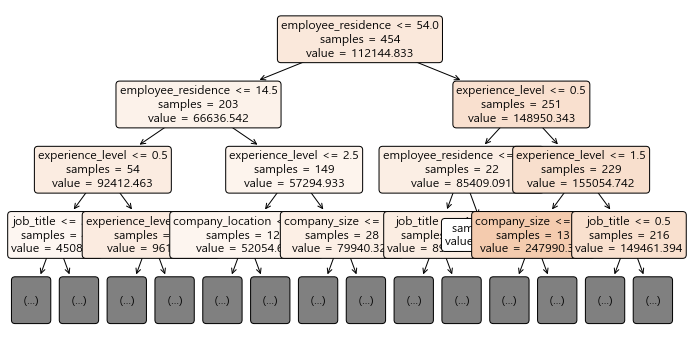

In [17]:
from sklearn.tree import plot_tree
plt.figure(figsize=(12,6))
plot_tree(r_model, max_depth=3, filled=True, feature_names=feature_names,
          impurity=False, rounded=True, fontsize=12)
plt.show()

In [18]:
# 특성 중요도
print('특성 중요도:\n', r_model.feature_importances_)

특성 중요도:
 [0.18760801 0.00868755 0.11126545 0.02864957 0.50001239 0.04888069
 0.02650456 0.08839178]


In [41]:
X.shape[1]

8

In [46]:
np.arange(8)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [47]:
[0] * 8

[0, 0, 0, 0, 0, 0, 0, 0]

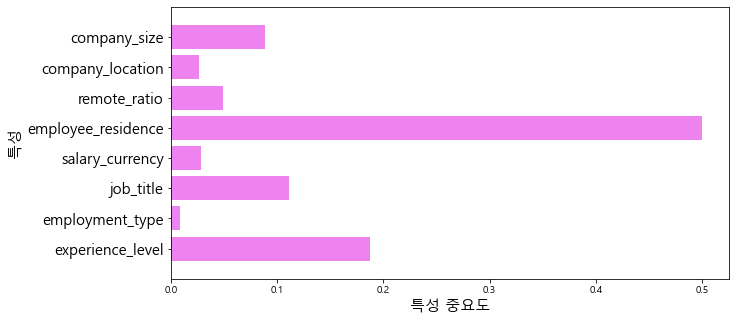

In [19]:
def plot_feature_importances_cancer(model):
    n_features = X.shape[1]
    plt.figure(figsize=(10,5))
    plt.barh(np.arange(n_features), model.feature_importances_, align='center', color='violet')
    plt.yticks(np.arange(n_features), feature, fontsize=15)
    plt.xlabel('특성 중요도', fontsize=15)
    plt.ylabel('특성', fontsize=15)
    plt.ylim(-1, n_features)
    plt.show()
    
plot_feature_importances_cancer(r_model)

### <span style = 'color : blue'> [ 랜덤 포레스트 ] </span>

In [20]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=5, max_features=0.7, max_samples=0.9,
                      n_estimators=50, oob_score=True)
regr = regr.fit(X_train, y_train)
regr

RandomForestRegressor(max_depth=5, max_features=0.7, max_samples=0.9,
                      n_estimators=50, oob_score=True)

In [21]:
# 특성 중요도
print('특성 중요도:\n', regr.feature_importances_)

특성 중요도:
 [0.18344828 0.00447939 0.07029181 0.07269204 0.41605515 0.01296086
 0.17468079 0.06539167]


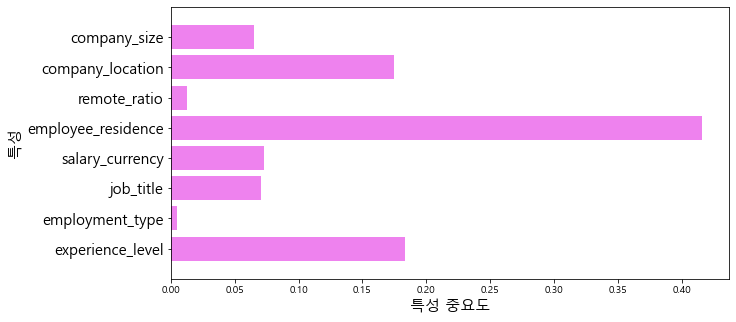

In [22]:
plot_feature_importances_cancer(regr)

### <span style = 'color : blue'> 교차검증 (CV) </span>

In [23]:
from sklearn.model_selection import cross_val_score, cross_validate # 각 활용처 알아보고 cross_val_predict,
result = cross_val_score(regr, X, y, cv=10)

In [24]:
allResult = cross_validate(regr, X, y, 
                           return_train_score=True,
                           cv=10)

In [25]:
resultDF1 = pd.DataFrame(allResult)
resultDF1[['test_score', 'train_score']]

,test_score,train_score
0,0.354697,0.563239
1,0.406731,0.579688
2,0.376500,0.559878
3,0.574255,0.535830
4,0.191062,0.564668
5,0.418900,0.560818
6,0.431505,0.568726
7,0.529619,0.555487
8,0.422078,0.565807
9,0.215101,0.567867


### <span style = 'color : blue'> KFold </span>

In [26]:
# Splitter 객체 생성 - KFold()
from sklearn.model_selection import KFold

kSplitter = KFold(n_splits=10, shuffle=True)

In [27]:
allResult1 = cross_validate(regr, X, y, 
                           return_train_score=True,
                           return_estimator=True,
                           cv=kSplitter)

resultDF1 = pd.DataFrame(allResult1)
resultDF1[['test_score', 'train_score']]

,test_score,train_score
0,0.377395,0.579565
1,0.565259,0.547711
2,0.373855,0.573446
3,0.351565,0.559247
4,0.410635,0.563144
5,0.320012,0.575273
6,0.580758,0.551811
7,0.388444,0.562603
8,0.656343,0.550282
9,0.444212,0.557617


### <span style = 'color : blue'> 하이퍼파라미터 조절 </span>

In [28]:
# for문으로 파라미터 하나씩 높은 것 찾아나가기 (여러 파라미터 함께 쓰였을 경우, 달라질 것 생각 못함)
for i in range(10,201,10):
  r_model = RandomForestRegressor(n_estimators = i)
  r_model.fit(X_train, y_train)

  relation_square = r_model.score(X_train, y_train)
  print('결정계수 : ', round(relation_square,3))

결정계수 :  0.694
결정계수 :  0.702
결정계수 :  0.702
결정계수 :  0.704
결정계수 :  0.699
결정계수 :  0.71
결정계수 :  0.707
결정계수 :  0.704
결정계수 :  0.707
결정계수 :  0.703
결정계수 :  0.704
결정계수 :  0.704
결정계수 :  0.703
결정계수 :  0.706
결정계수 :  0.709
결정계수 :  0.708
결정계수 :  0.708
결정계수 :  0.705
결정계수 :  0.71
결정계수 :  0.706


### <span style = 'color : blue'> GridSearchCV </span>

In [29]:
parameters_r = {'n_estimators': [50, 100, 150, 200, 400],
                  'max_depth'    :  [5, 10, 15, 20],
                  'max_samples' : [0.2, 0.4, 0.7, 0.8, 0.9, 1.0],
                  'max_features'    : [0.2, 0.4, 0.7, 0.8, 0.9, 1.0]
                 }

In [30]:
grid_reg = GridSearchCV(estimator=regr, param_grid = parameters_r, cv = 2, n_jobs=-1)
grid_reg.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print(" Result " )
print("\n [Best estimator] :\n",grid_reg.best_estimator_)
print("\n [Best score] :\n",grid_reg.best_score_)
print("\n [Best parameters] :\n",grid_reg.best_params_)

### <span style = 'color : blue'> 모델 평가 </span>

In [ ]:
# regr.score(X_train, y_train)
print("훈  련 세트 : {:.3f}".format(regr.score(X_train, y_train)))
print("테스트 세트 : {:.3f}".format(regr.score(X_test, y_test)))
print('\n(파라미터 변경전 : n_jobs=-1,oob_score=True)\n훈  련 세트 : 0.715\n테스트 세트 : 0.496')

### <span style = 'color : blue'> 예측값과 실제값 비교 </span>

In [ ]:
X_test = X_test.tolist()
y_test = y_test.tolist()

In [ ]:
predicted = regr.predict(X_test)
predicted = predicted.tolist()

In [ ]:
pred_df = pd.DataFrame({ 'test값':y_test, 'predict값':predicted })

In [ ]:
plt.figure(figsize=(15,7))
plt.title('< 랜덤포레스트_Test값과 Predict값의 비교 >', fontsize=20)
plt.plot(pred_df)
plt.legend('TP')
plt.show()

---

### <span style = 'color : blue'> [ 그래디언트부스팅 ] </span>

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(alpha=0.1, learning_rate=0.03, max_depth=4, subsample=0.9)
reg.fit(X_train, y_train)

### <span style = 'color : blue'> 교차검증 (CV) </span>

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate # 각 활용처 알아보고 cross_val_predict,
result = cross_val_score(reg, X, y, cv=10)

In [ ]:
allResult = cross_validate(reg, X, y, 
                           return_train_score=True,
                           cv=10)

In [ ]:
resultDF1 = pd.DataFrame(allResult)
resultDF1[['test_score', 'train_score']]

### <span style = 'color : blue'> KFold </span>

In [ ]:
# Splitter 객체 생성 - KFold()
from sklearn.model_selection import KFold

kSplitter = KFold(n_splits=10, shuffle=True)

In [ ]:
allResult1 = cross_validate(reg, X, y, 
                           return_train_score=True,
                           return_estimator=True,
                           cv=kSplitter)

resultDF1 = pd.DataFrame(allResult1)
resultDF1[['test_score', 'train_score']]

### <span style = 'color : blue'> 하이퍼파라미터 조절 </span>

### <span style = 'color : blue'> GridSearchCV </span>

In [ ]:
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
              'alpha'    : [0.1, 0.3, 0.5, 0.7],
              'n_estimators' : [100,500,1000, 1500],
              'max_depth'    : [4,6,8,10],
               'subsample'   : [0.3, 0.5, 0.9, 1.5]
                 }

In [ ]:
grid_reg = GridSearchCV(estimator=reg, param_grid = parameters, cv = 2, n_jobs=-1)
grid_reg.fit(X_train, y_train)

In [ ]:
print(" Result " )
print("\n [Best estimator] :\n",grid_reg.best_estimator_)
print("\n [Best score] :\n",grid_reg.best_score_)
print("\n [Best parameters] :\n",grid_reg.best_params_)

### <span style = 'color : blue'> 모델 평가 </span>

In [ ]:
print("훈  련 세트 : {:.3f}".format(reg.score(X_train, y_train)))
print("테스트 세트 : {:.3f}".format(reg.score(X_test, y_test)))
print('\n(파라미터 변경전 : learning_rate=0.01, max_depth=6, subsample=0.9, n_estimators=500, alpha=0.01)\n훈  련 세트 : 0.736\n테스트 세트 : 0.500')

<span style = 'color : red'> **훈련 스코어는 감소, 테스트 스코어는 증가하는** </span>  
<span style = 'color : red'> **일부 임의로 입력하는 것이 효과가 더 나은 경우도 발생하기도** </span>  

### <span style = 'color : blue'> 예측값과 실제값 비교 </span>

In [ ]:
predicted_g = reg.predict(X_test)
predicted_g = predicted_g.tolist()

In [ ]:
pred_df_g = pd.DataFrame({ 'test값':y_test, 'predict값':predicted_g })

In [ ]:
plt.figure(figsize=(15,7))
plt.title('< 그래디언트부스팅_Test값과 Predict값의 비교 >', fontsize=20)
plt.plot(pred_df_g)
plt.legend('TP')

---

### <span style = 'color : blue'>  [ 릿지/라쏘 <- 랜덤포레스트 ] </span>
---
범주형 데이터는 릿지/라쏘를 쓸 경우 직선처럼 그려져서 효과는x

In [ ]:
from sklearn.linear_model import Ridge
model_rid = Ridge(alpha=0.01).fit(X_train, y_train)
print('훈  련 세트 : {:.2f}'.format(model_rid.score(X_train, y_train)))
print('테스트 세트 : {:.2f}'.format(model_rid.score(X_test, y_test)))

In [ ]:
from sklearn.linear_model import Lasso
model_la = Ridge(alpha=0.02).fit(X_train, y_train)
print('훈  련 세트 : {:.2f}'.format(model_la.score(X_train, y_train)))
print('테스트 세트 : {:.2f}'.format(model_la.score(X_test, y_test)))

---

### <span style = 'color : blue'> [ 히스트그래디언팅 ] </span>

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
reg_h = HistGradientBoostingRegressor(loss='poisson', learning_rate=0.35, max_depth=8, max_iter=500)
reg_h.fit(X_train, y_train)

### <span style = 'color : blue'> 교차검증 (CV) </span>

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate # 각 활용처 알아보고 cross_val_predict,
result = cross_val_score(reg_h, X, y, cv=10)

In [ ]:
allResult = cross_validate(reg_h, X, y, 
                           return_train_score=True,
                           cv=10)

In [ ]:
resultDF1 = pd.DataFrame(allResult)
resultDF1[['test_score', 'train_score']]

### <span style = 'color : blue'> KFold </span>

In [ ]:
# Splitter 객체 생성 - KFold()
from sklearn.model_selection import KFold

kSplitter = KFold(n_splits=10, shuffle=True)

In [ ]:
allResult1 = cross_validate(reg_h, X, y, 
                           return_train_score=True,
                           return_estimator=True,
                           cv=kSplitter)

resultDF1 = pd.DataFrame(allResult1)
resultDF1[['test_score', 'train_score']]

### <span style = 'color : blue'> 하이퍼파라미터 조절 </span>

### <span style = 'color : blue'> GridSearchCV </span>

In [ ]:
parameters_h = {'learning_rate': [0.01,0.02,0.03,0.04],
                'max_iter'    : [100, 200, 300, 500],
                'max_depth'    : [4,6,8,10],
                 }

In [ ]:
grid_reg = GridSearchCV(estimator=reg_h, param_grid = parameters_h, cv = 2, n_jobs=-1)
grid_reg.fit(X_train, y_train)

In [ ]:
print(" Result " )
print("\n [Best estimator] :\n",grid_reg.best_estimator_)
print("\n [Best score] :\n",grid_reg.best_score_)
print("\n [Best parameters] :\n",grid_reg.best_params_)

### <span style = 'color : blue'> 모델 평가 </span>

In [ ]:
print("훈  련 세트 : {:.3f}".format(reg_h.score(X_train, y_train)))
print("테스트 세트 : {:.3f}".format(reg_h.score(X_test, y_test)))
print('\n(파라미터 변경전 : )\n훈  련 세트 : 0.633\n테스트 세트 : 0.384')

### <span style = 'color : blue'> 예측값과 실제값 비교 </span>

In [ ]:
predicted_h = reg_h.predict(X_test)
predicted_h = predicted_h.tolist()

In [ ]:
pred_df_h = pd.DataFrame({ 'test값':y_test, 'predict값':predicted_h })

In [ ]:
plt.figure(figsize=(15,7))
plt.title('< 히스트그래디언팅_Test값과 Predict값의 비교 >', fontsize=20)
plt.plot(pred_df_h)
plt.legend('TP')

---

---

In [ ]:
# 파라미터 개수에 따른 score 변화 살피기

n_feature = X.shape[1]  # X.shape[1] = 8

score_n_tr_est = []
score_n_te_est = []
score_m_tr_mft = []
score_m_te_mft = []

for i in np.arange(1, n_feature+1): # n_estimators와 mat_features는 모두 0보다 큰 정수여야 하므로 1부터 시작
    params_n = {'n_estimators':i, 'max_features':'auto', 'n_jobs':-1} # **kwargs parameter
    params_m = {'n_estimators':10, 'max_features':i, 'n_jobs':-1}

    forest_n = RandomForestRegressor(**params_n).fit(X_train, y_train)
    forest_m = RandomForestRegressor(**params_m).fit(X_train, y_train)

    score_n_tr = forest_n.score(X_train, y_train)
    score_n_te = forest_n.score(X_test, y_test)
    score_m_tr = forest_m.score(X_train, y_train)
    score_m_te = forest_m.score(X_test, y_test)

    score_n_tr_est.append(score_n_tr)
    score_n_te_est.append(score_n_te)
    score_m_tr_mft.append(score_m_tr)
    score_m_te_mft.append(score_m_te)

index = np.arange(len(score_n_tr_est))
plt.plot(index, score_n_tr_est, label='n_estimators train score', color='lightblue', ls='--') # ls: linestyle
plt.plot(index, score_m_tr_mft, label='max_features train score', color='orange', ls='--')
plt.plot(index, score_n_te_est, label='n_estimators test score', color='lightblue')
plt.plot(index, score_m_te_mft, label='max_features test score', color='orange')
plt.legend(loc='center', bbox_to_anchor=(0.5, 1.1),
           ncol=2, fancybox=True, shadow=False) # fancybox: 박스모양, shadow: 그림자
plt.xlabel('number of parameter', size=15)
plt.ylabel('score', size=15)
plt.show()
print('   => 그래프를 통해, parameter의 갯수가 적을 때보다 많을때가 성능이 더 좋아보임.')

---